<font size = 10>\
    Project 4 - Building a scoring model

Import usefull package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer

from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import roc_auc_score ,f1_score,accuracy_score,precision_score,recall_score,plot_confusion_matrix

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold,RandomizedSearchCV

from sklearn.linear_model import LogisticRegression, RidgeClassifier, ElasticNet, SGDClassifier

from sklearn.datasets import make_classification

from sklearn.dummy import DummyClassifier

from sklearn.utils import resample

from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

from sklearn.decomposition import PCA

from sklearn.kernel_ridge import KernelRidge

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.tree import DecisionTreeClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.base import BaseEstimator

import lime

import eli5

from eli5.sklearn import PermutationImportance

from pdpbox import pdp, get_dataset, info_plots

import shap

C:\Users\Soyann\Code\Install\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Soyann\Code\Install\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load dataset

## Working with the Loan appplication data set

### Data

In [83]:
app_data = pd.read_csv('data/application_train.csv')
print('Training data shape: ', app_data.shape)

Training data shape:  (307511, 122)


### Kaggle Testing dataset

In [84]:
app_kaggle = pd.read_csv('data/application_test.csv')
print('Testing data shape: ', app_kaggle.shape)

Testing data shape:  (48744, 121)


# Exploratory Data Analysis

## Distribution of the target

In [85]:
app_data['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Text(0, 0.5, 'Counts')

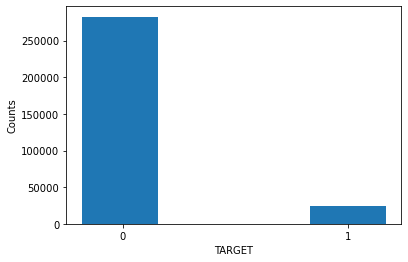

In [86]:
plt.hist(app_data['TARGET'],bins=4,align='mid')
plt.xticks([0.135,0.875],['0','1'])
plt.xticks
plt.xlabel('TARGET')
plt.ylabel('Counts')

## Missing values

In [87]:
(app_data.isna().sum(axis = 0) / app_data.shape[0]).sort_values(ascending=False)[0:20]

COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_MEDI    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_MEDI       0.683550
LIVINGAPARTMENTS_MODE       0.683550
LIVINGAPARTMENTS_AVG        0.683550
FLOORSMIN_MEDI              0.678486
FLOORSMIN_MODE              0.678486
FLOORSMIN_AVG               0.678486
YEARS_BUILD_MEDI            0.664978
YEARS_BUILD_AVG             0.664978
YEARS_BUILD_MODE            0.664978
OWN_CAR_AGE                 0.659908
LANDAREA_MODE               0.593767
LANDAREA_AVG                0.593767
LANDAREA_MEDI               0.593767
dtype: float64

## Feature types

In [88]:
app_data.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

### Encoding Categorical Variables

Encode with labelEncoder for 2 unique categories or use get_dumies

In [89]:
from sklearn.preprocessing import LabelEncoder


# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_data:
    if app_data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_data[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_data[col])
            # Transform both training and testing data
            app_data[col] = le.transform(app_data[col])
            app_kaggle[col] = le.transform(app_kaggle[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [90]:
# one-hot encoding of categorical variables
app_data = pd.get_dummies(app_data)
app_kaggle = pd.get_dummies(app_kaggle)

print('Training Features shape: ', app_data.shape)
print('Testing Features shape: ', app_kaggle.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [91]:
train_labels = app_data['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_data, app_kaggle = app_data.align(app_kaggle, join = 'inner', axis = 1)

# Add the target back in
app_data['TARGET'] = train_labels

print('Training Features shape: ', app_data.shape)
print('Testing Features shape: ', app_kaggle.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


### Outliers in numerical features

In [92]:
app_data.shape

(307511, 240)

In [93]:
app_kaggle.shape

(48744, 239)

Print the describe function on the numerical columns to check for outliers

In [94]:
app_num=app_data.select_dtypes(include=['float64','int64'])

In [95]:
def show_describe(i):
    return app_num.describe().iloc[:,(i-1)*10:i*10]

In [96]:
widgets.interact(show_describe, i=10)

interactive(children=(IntSlider(value=10, description='i', max=30, min=-10), Output()), _dom_classes=('widget-…

<function __main__.show_describe(i)>

In [97]:
suspected_outliers=['DAYS_EMPLOYED',
                    'OBS_30_CNT_SOCIAL_CIRCLE',
                    'DEF_30_CNT_SOCIAL_CIRCLE',
                    'OBS_60_CNT_SOCIAL_CIRCLE',
                    'DEF_60_CNT_SOCIAL_CIRCLE',
                    'AMT_REQ_CREDIT_BUREAU_HOUR',
                    'AMT_REQ_CREDIT_BUREAU_DAY',
                    'AMT_REQ_CREDIT_BUREAU_WEEK',
                    'AMT_REQ_CREDIT_BUREAU_MON',
                    'AMT_REQ_CREDIT_BUREAU_QRT',
                    'AMT_REQ_CREDIT_BUREAU_YEAR',
                    'HOUR_APPR_PROCESS_START'
                   ]

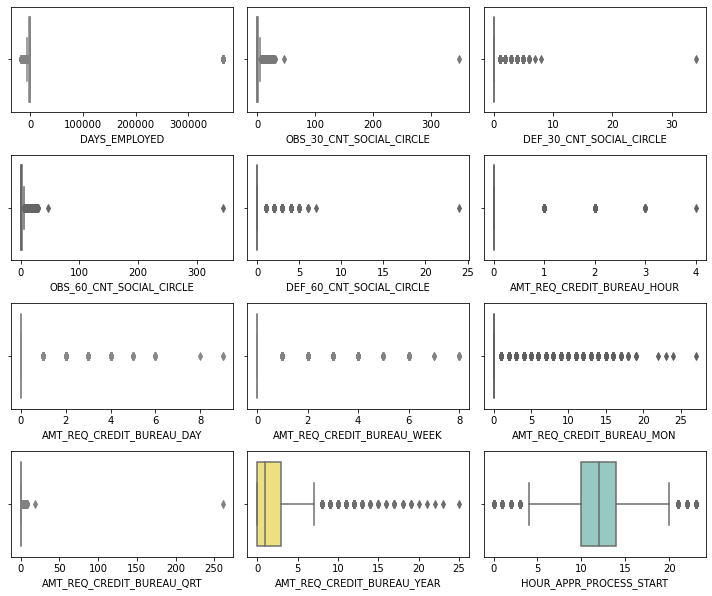

In [29]:
i=0
colors=sns.color_palette("Set3", 14)
plt.figure(figsize=(10,10))
for col in suspected_outliers:
    i+=1
    plt.subplot(5,3,i)
    sns.boxplot(x=app_data[col],color=colors[i%12])
plt.tight_layout()

#### DAYS_EMPLOYED

In [98]:
app_data[app_data['DAYS_EMPLOYED']>200000].shape

(55374, 240)

<AxesSubplot:xlabel='DAYS_EMPLOYED'>

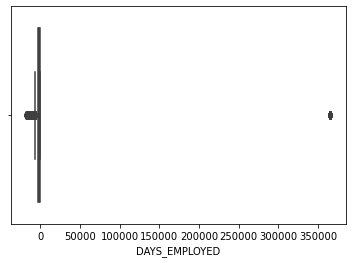

In [31]:
sns.boxplot(x=app_data['DAYS_EMPLOYED'])

In [99]:
# Create an anomalous flag column
app_data['DAYS_EMPLOYED_ANOM'] = app_data["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_data['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# Apply the same steps to the test data
app_kaggle['DAYS_EMPLOYED_ANOM'] = app_kaggle["DAYS_EMPLOYED"] == 365243
app_kaggle["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)



#### Social circle features

In [100]:
app_data[app_data['OBS_30_CNT_SOCIAL_CIRCLE']>100].shape

(1, 241)

In [101]:
app_data.drop(index=app_data[app_data['OBS_30_CNT_SOCIAL_CIRCLE']>100].index,inplace=True)

<AxesSubplot:xlabel='DEF_30_CNT_SOCIAL_CIRCLE'>

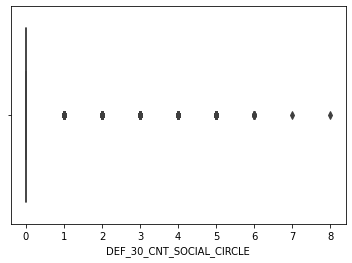

In [102]:
sns.boxplot(x=app_data['DEF_30_CNT_SOCIAL_CIRCLE'])

In [103]:
app_data[(app_data['DEF_30_CNT_SOCIAL_CIRCLE']>1.5) & (app_data['DEF_30_CNT_SOCIAL_CIRCLE']<2.5)].shape

(5323, 241)

In [104]:
app_data[(app_data['OBS_30_CNT_SOCIAL_CIRCLE']>15) & (app_data['OBS_30_CNT_SOCIAL_CIRCLE']<25)].shape

(418, 241)

<AxesSubplot:xlabel='DEF_60_CNT_SOCIAL_CIRCLE', ylabel='OBS_60_CNT_SOCIAL_CIRCLE'>

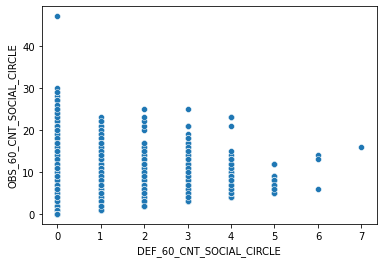

In [105]:
sns.scatterplot(x=app_data['DEF_60_CNT_SOCIAL_CIRCLE'],y=app_data['OBS_60_CNT_SOCIAL_CIRCLE'])

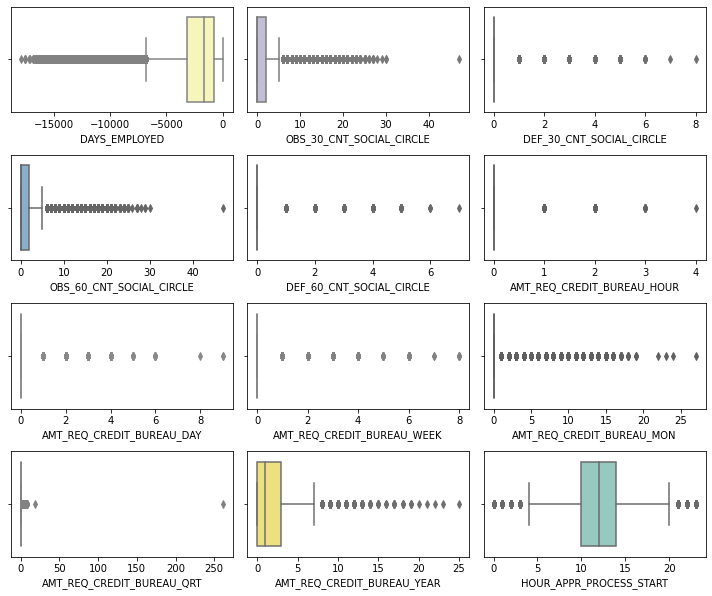

In [40]:
i=0
colors=sns.color_palette("Set3", 14)
plt.figure(figsize=(10,10))
for col in suspected_outliers:
    i+=1
    plt.subplot(5,3,i)
    sns.boxplot(x=app_data[col],color=colors[i%12])
plt.tight_layout()

#### Amount of request features

<AxesSubplot:xlabel='AMT_REQ_CREDIT_BUREAU_QRT'>

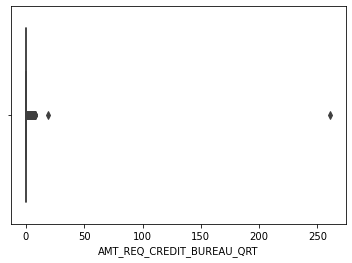

In [94]:
sns.boxplot(x=app_data['AMT_REQ_CREDIT_BUREAU_QRT'])

In [106]:
app_data[app_data['AMT_REQ_CREDIT_BUREAU_QRT']>15].shape

(2, 241)

In [107]:
app_data.drop(index=app_data[app_data['AMT_REQ_CREDIT_BUREAU_QRT']>15].index,inplace=True)

<AxesSubplot:xlabel='AMT_REQ_CREDIT_BUREAU_QRT'>

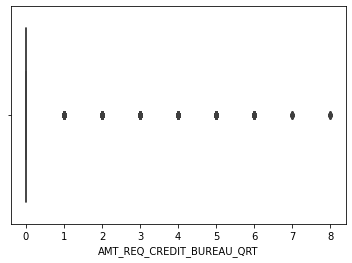

In [108]:
sns.boxplot(x=app_data['AMT_REQ_CREDIT_BUREAU_QRT'])

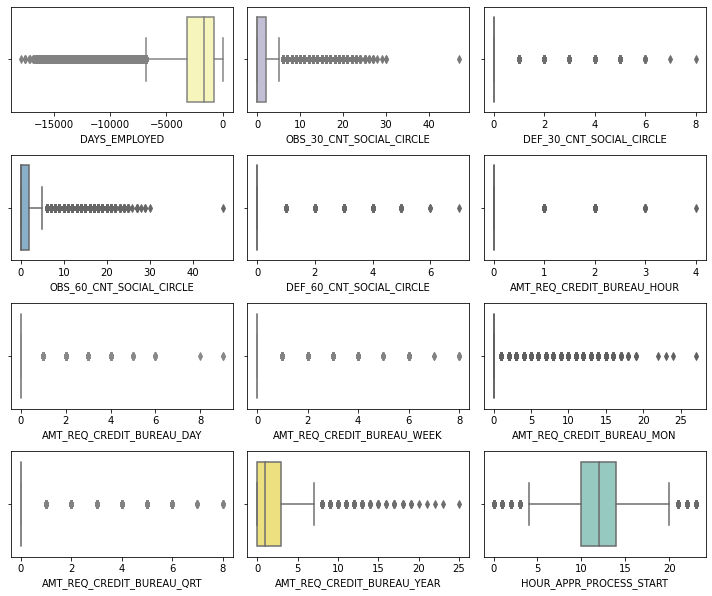

In [47]:
i=0
colors=sns.color_palette("Set3", 14)
plt.figure(figsize=(10,10))
for col in suspected_outliers:
    i+=1
    plt.subplot(5,3,i)
    sns.boxplot(x=app_data[col],color=colors[i%12])
plt.tight_layout()

## SK_ID_CURR

In [109]:
app_data.index = app_data['SK_ID_CURR']
app_kaggle.index = app_kaggle['SK_ID_CURR']

In [110]:
app_data = app_data.drop(columns=['SK_ID_CURR'])
app_kaggle = app_kaggle.drop(columns=['SK_ID_CURR'])

## Saving datasets

In [111]:
app_data.to_pickle('data/app_data_outliers')
app_kaggle.to_pickle('data/app_kaggle_outliers')

## Correlations (not used in presentation)

In [2]:
app_data=pd.read_pickle('data/app_data_outliers')
app_kaggle=pd.read_pickle('data/app_kaggle_outliers')
print('app_data shape :', app_data.shape)
print('app_kaggle shape :',app_kaggle.shape)

app_data shape : (307508, 240)
app_kaggle shape : (48744, 239)


In [19]:
#correlation_matrix=app_data.corr()

In [24]:
#correlation_matrix.fillna(0,inplace=True)

In [25]:
#correlation_matrix.to_pickle('data/correlation_matrix')

In [117]:
correlation_matrix=pd.read_pickle('data/correlation_matrix')

In [118]:
#get index and columns
I = correlation_matrix.index
C = correlation_matrix.columns

# fills the diagonal with,get absolute value and upper triangle
np.fill_diagonal(correlation_matrix.values,0)
correlation_abs_matrix = correlation_matrix.abs()
correlation_abs_matrix = pd.DataFrame(np.triu(correlation_abs_matrix),index=I,columns=C)

Let's look at the value over 0.95

In [119]:
couples=[]
for row in correlation_abs_matrix.index:
    for col in correlation_abs_matrix.columns:
        if correlation_abs_matrix.loc[row,col] > 0.95:
            couples.append([row,col,correlation_abs_matrix.loc[row,col]])
couples = pd.DataFrame(couples,columns=['feature_1','feature_2','corr'])

In [120]:
couples.sort_values(by='corr',ascending=False)

,feature_1,feature_2,corr
47,CODE_GENDER_F,CODE_GENDER_M,0.999971
2,FLAG_EMP_PHONE,ORGANIZATION_TYPE_XNA,0.999868
48,NAME_INCOME_TYPE_Pensioner,ORGANIZATION_TYPE_XNA,0.999648
1,FLAG_EMP_PHONE,NAME_INCOME_TYPE_Pensioner,0.999515
11,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,0.998495
46,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,0.998380
21,FLOORSMIN_AVG,FLOORSMIN_MEDI,0.997241
19,FLOORSMAX_AVG,FLOORSMAX_MEDI,0.997034
17,ENTRANCES_AVG,ENTRANCES_MEDI,0.996886
15,ELEVATORS_AVG,ELEVATORS_MEDI,0.996099


In [101]:
app_data_corr = app_data.drop(columns=couples['feature_1'])
app_kaggle_corr = app_data.drop(columns=couples['feature_1'])

# Baseline

In [1]:
def show_score(y_test,y_pred_d_cls_prob,y_pred_d_cls):
    '''Compute and shows different scores'''
    a=roc_auc_score(y_test,y_pred_d_cls_prob)
    b=f1_score(y_test,y_pred_d_cls)
    c=accuracy_score(y_test,y_pred_d_cls)
    d=precision_score(y_test,y_pred_d_cls)
    e=recall_score(y_test,y_pred_d_cls)
    print('ROC AUC   :',a)
    print('F1        :',b)
    print('Accuracy  :',c)
    print('Precision :',d)
    print('Recall    :',e)

## Test and Train split

In [69]:
X = app_data.drop( columns = ['TARGET'])
y = app_data['TARGET']
features = X.columns

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2)

In [128]:
y_test.shape

(46127,)

## Undersampling

In [85]:
X_train_under, y_train_under = resample(X_train,y_train,n_samples = 20000, stratify = y_train,random_state=2)

## Dummy classifier

In [7]:
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=2,random_state=5)
scoring = {'ROC AUC': 'roc_auc',
           'F1': 'f1',
           'Accuracy': 'accuracy',
           'Precision' : 'precision',
           'Recall' :'recall'}

In [8]:
dummy_cls = Pipeline( [('imp' , SimpleImputer(strategy='median')),
                       ('scaler' , StandardScaler()),
                       ('Dummy_cls', DummyClassifier(strategy='stratified'))])

In [9]:
scores = cross_validate(dummy_cls,X_train_under,y_train_under, scoring = scoring, cv=cv)
for key in scores.keys():
    print (f'Mean {key} : {scores[key].mean()}' )

Mean fit_time : 0.5514930963516236
Mean score_time : 0.10369939804077148
Mean test_ROC AUC : 0.5011884289396177
Mean test_F1 : 0.08445056244000175
Mean test_Accuracy : 0.8535499999999999
Mean test_Precision : 0.08503437509330283
Mean test_Recall : 0.08425350816655165


In [10]:
dummy_cls.fit(X_train_under,y_train_under)

Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('Dummy_cls', DummyClassifier(strategy='stratified'))])

In [11]:
show_score(y_test,dummy_cls.predict_proba(X_test)[:,1],dummy_cls.predict(X_test))

NameError: name 'show_score' is not defined

## Kaggle Submission

In [123]:
def kaggle_submit(estimator,data,output_name = 'submission_default.csv'):
    '''Calculate and transform the data in the appropriate format for submission on Kaggle'''
    kaggle_pred = estimator.predict_proba(data)[:,1]
    kaggle_df = pd.DataFrame(data.index,columns=['SK_ID_CURR'])
    kaggle_df['TARGET'] = kaggle_pred
    kaggle_df.to_csv('data/'+output_name,index = False)

# Feature Importance

In [5]:

def features_importance_lg(estimator,features,n_features_plot = 40,n_features_cum = 130,plot = False):
    '''compute statistics base on feature importance of an estimator
    plot individual feature importance and cumulative importance
    returns feature importance'''
    estimator_coef=pd.DataFrame(estimator.coef_.reshape(features.shape[0],),columns=['coeff'])
    estimator_coef['abs_coeff']=np.abs(estimator_coef['coeff'])
    estimator_coef['relative_importance']=estimator_coef['coeff'] / estimator_coef['abs_coeff'].sum()
    estimator_coef['abs_relative_importance']=estimator_coef['abs_coeff']/estimator_coef['abs_coeff'].sum()
    estimator_coef['sign']=np.sign(estimator_coef['coeff'])
    estimator_coef['feature']=features.values
    estimator_coef = estimator_coef.sort_values(by='abs_relative_importance',ascending=False)
    estimator_coef['cum_sum_abs_rel_imp']=np.cumsum(estimator_coef['abs_relative_importance'])
    
    if plot == True:
        plt.figure(figsize=(7,7))
        sns.barplot(data=estimator_coef.head(n_features_plot),x ='relative_importance',y='feature',hue='sign',dodge=False)
        sns.relplot(data=estimator_coef.head(n_features_cum),y ='cum_sum_abs_rel_imp',x=np.arange(1,n_features_cum+1),kind='line')
        plt.ylabel('cumulative feature importance')
        plt.xlabel('number of features')
    return estimator_coef

In [4]:
# function which compute statistics base on feature coeff of an estimator
def features_importance_rdf(estimator,features,n_features_plot = 40,n_features_cum = 130, plot = False):
    '''compute statistics base on feature coef of an estimator
    plot individual feature importance and cumulative importance
    returns feature coeff'''
    estimator_coef=pd.DataFrame(estimator.feature_importances_.reshape(features.shape[0],),columns=['coeff'])
    estimator_coef['importance']=np.abs(estimator_coef['coeff'])
    estimator_coef['abs_relative_importance']=estimator_coef['importance']/estimator_coef['importance'].sum()
    estimator_coef['sign']=np.sign(estimator_coef['coeff'])
    estimator_coef['feature']=features.values
    estimator_coef = estimator_coef.sort_values(by='abs_relative_importance',ascending=False)
    estimator_coef['cum_sum_abs_rel_imp']=np.cumsum(estimator_coef['abs_relative_importance'])
    
    if plot == True:
        plt.figure(figsize=(7,7))
        sns.barplot(data=estimator_coef.head(n_features_plot),x ='abs_relative_importance',y='feature',hue='sign',dodge=False)
        sns.relplot(data=estimator_coef.head(n_features_cum),y ='cum_sum_abs_rel_imp',x=np.arange(1,n_features_cum+1),kind='line')
        plt.ylabel('cumulative feature importance')
        plt.xlabel('number of features')
    return estimator_coef

In [14]:
feature_importance={}

## Decision tree

In [15]:
pipeline_tree = Pipeline(
                        [('imp', SimpleImputer(strategy='median')),
                         ('scaler' , StandardScaler()),
                         ('tree' , DecisionTreeClassifier(class_weight='balanced'))]) 
                        

In [16]:
pipeline_tree.fit(X_train_under,y_train_under)

Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('tree', DecisionTreeClassifier(class_weight='balanced'))])

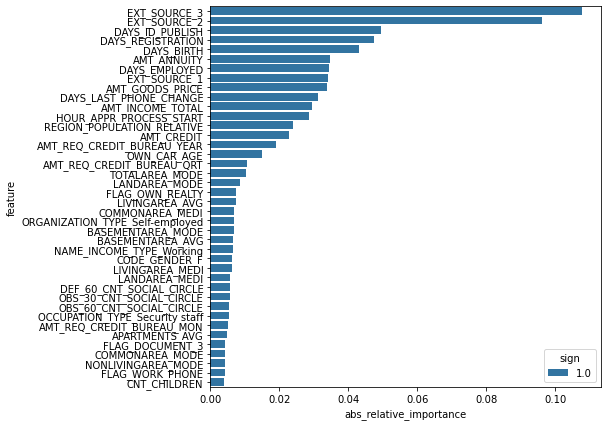

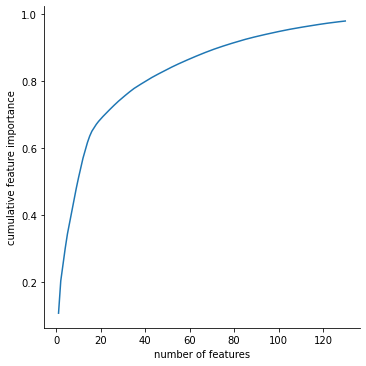

In [129]:
feature_importance['tree'] = features_importance_rdf(pipeline_tree.named_steps['tree'],features,plot=True)

## LDA

In [18]:
pipeline_lda = Pipeline(
                        [('imp', SimpleImputer(strategy='median')),
                         ('scaler' , StandardScaler()),
                         ('lda' , LinearDiscriminantAnalysis())]) 

In [19]:
pipeline_lda.fit(X_train_under,y_train_under)

Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('lda', LinearDiscriminantAnalysis())])

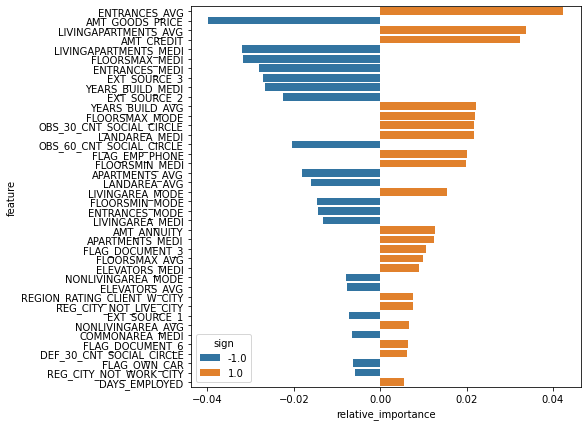

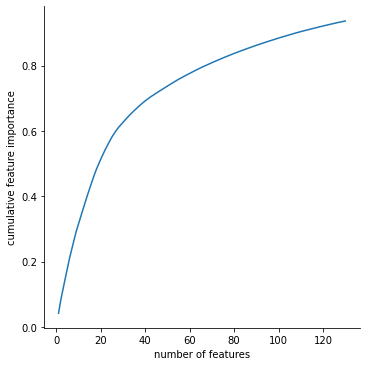

In [130]:
feature_importance['lda'] = features_importance_lg(pipeline_lda.named_steps['lda'],features,plot=True)

## Logistic regression

In [21]:
pipeline_lr = Pipeline(
                        [('imp', SimpleImputer(strategy='median')),
                         ('scaler' , StandardScaler()),
                         ('lr' , LogisticRegression(C = 0.01, max_iter = 200, class_weight = 'balanced'))]) 

In [22]:
pipeline_lr.fit(X_train_under,y_train_under)

Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=200))])

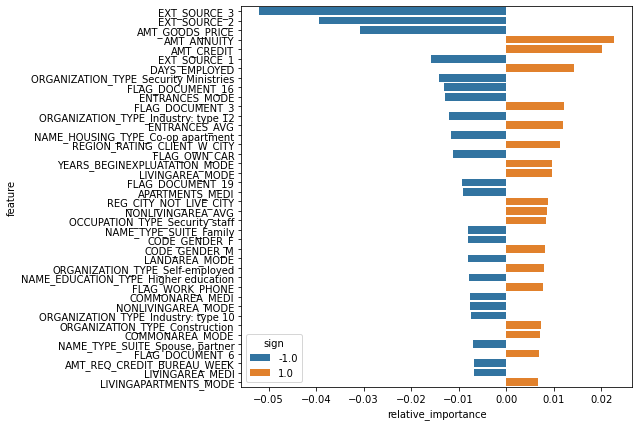

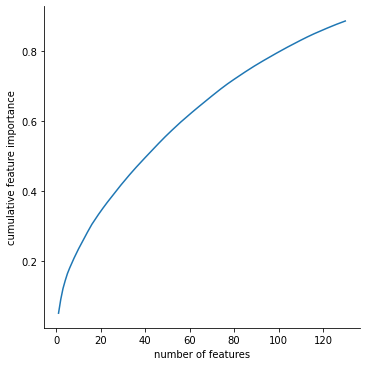

In [131]:
feature_importance['lr'] = features_importance_lg(pipeline_lr.named_steps['lr'],features,plot=True)

## Random forest

In [24]:
pipeline_rdf = Pipeline(
                        [('imp', SimpleImputer(strategy='median')),
                         ('scaler' , StandardScaler()),
                         ('rdf' , RandomForestClassifier(n_estimators= 100, class_weight="balanced",criterion='gini'))]) 

In [25]:
pipeline_rdf.fit(X_train_under,y_train_under)

Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('rdf', RandomForestClassifier(class_weight='balanced'))])

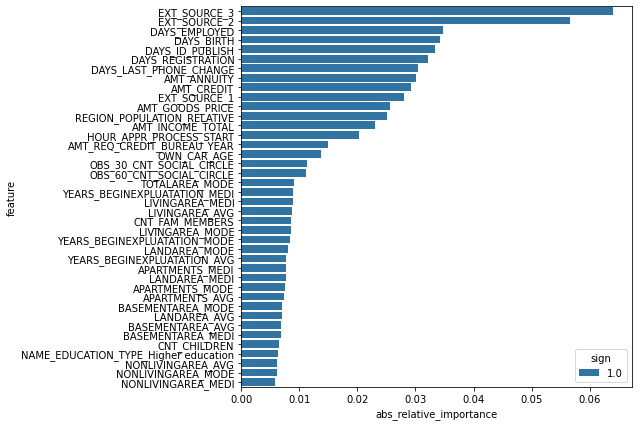

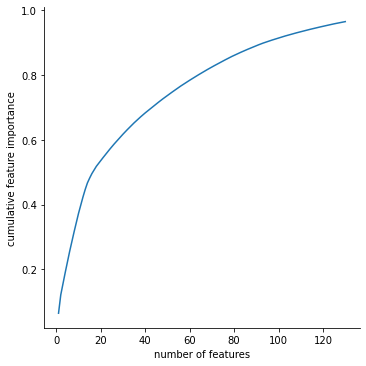

In [132]:
feature_importance['rdf'] = features_importance_rdf(pipeline_rdf.named_steps['rdf'],features,plot = True)

## SGD Classifier

In [27]:
pipeline_sgd = Pipeline(
                        [('imp', SimpleImputer(strategy='median')),
                         ('scaler' , StandardScaler()),
                         ('sgd' , SGDClassifier(class_weight='balanced',loss='modified_huber'))]) 

In [28]:
pipeline_sgd.fit(X_train_under,y_train_under)

Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(class_weight='balanced',
                               loss='modified_huber'))])

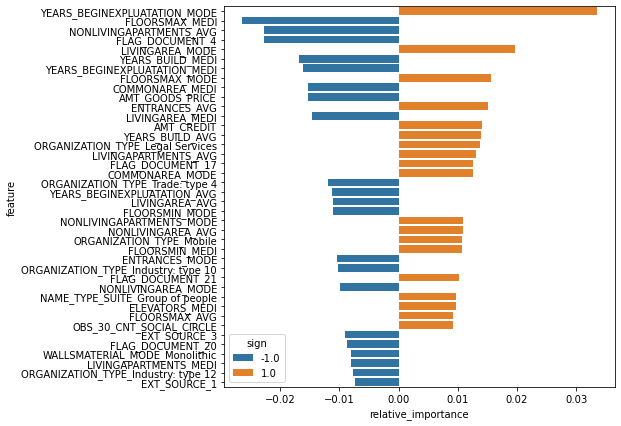

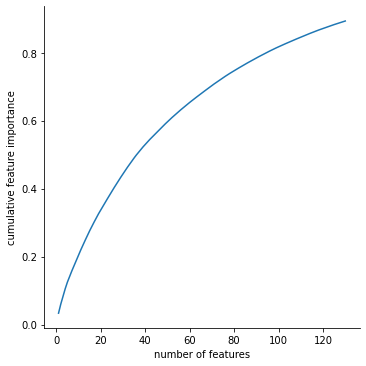

In [133]:
feature_importance['SGDClassifier'] = features_importance_lg(pipeline_sgd.named_steps['sgd'],features,plot = True)

## LGB

In [30]:
pipeline_lgb = Pipeline(
                        [('imp', SimpleImputer(strategy='median')),
                         ('scaler' , StandardScaler()),
                         ('lgb' , LGBMClassifier(class_weight='balanced'))]) 

In [31]:
pipeline_lgb.fit(X_train_under,y_train_under)

Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('lgb', LGBMClassifier(class_weight='balanced'))])

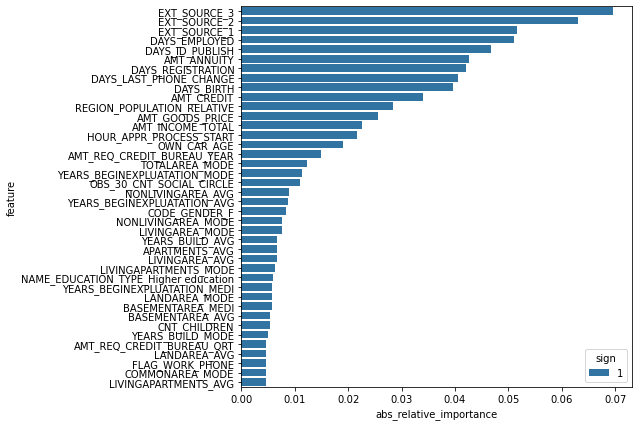

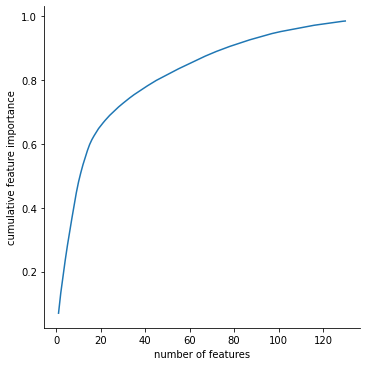

In [134]:
feature_importance['lgb'] = features_importance_rdf(pipeline_lgb.named_steps['lgb'],features,plot = True)

## Feature importance results

In [33]:
feature_importance.keys()

dict_keys(['tree', 'lda', 'lr', 'rdf', 'SGDClassifier', 'lgb'])

In [34]:
# Calculating different statistics for the feature importance
feature_importance_results = pd.DataFrame(index = features)
feature_importance_results['counts']=0
feature_importance_results['rank']=0
feature_importance_results['total importance']=0
feature_importance_results['appearance in top 40']=0

In [35]:
for key in feature_importance.keys():
    n = 0
    for feature in feature_importance[key]['feature']:
        if n <= 30:
            feature_importance_results.loc[feature,'counts']+=1
        feature_importance_results.loc[feature,'rank']+=n
        feature_importance_results.loc[feature,'total importance']+= feature_importance[key].where(feature_importance[key]['feature'] == feature )['abs_relative_importance'].sum()
        n+=1
feature_importance_results['total importance'] = feature_importance_results['total importance'] / feature_importance_results['total importance'].sum()
    

In [36]:
top_40_counts_index = feature_importance_results.sort_values(by=['counts'],ascending=False).head(40).index
feature_importance_results.loc[top_40_counts_index,'appearance in top 40']+=1

top_40_importance_index = feature_importance_results.sort_values(by=['total importance'],ascending=False).head(40).index
feature_importance_results.loc[top_40_importance_index,'appearance in top 40']+=1

top_40_rank_index = feature_importance_results.sort_values(by=['rank'],ascending=True).head(40).index
feature_importance_results.loc[top_40_rank_index,'appearance in top 40']+=1

In [37]:
feature_importance_results.sort_values(by=['appearance in top 40','total importance'],ascending=False).head(40)

,counts,rank,total importance,appearance in top 40
EXT_SOURCE_2,5,59,0.052213,3
EXT_SOURCE_3,5,53,0.045720,3
AMT_CREDIT,6,29,0.032153,3
DAYS_REGISTRATION,4,157,0.026477,3
DAYS_EMPLOYED,4,144,0.025900,3
AMT_GOODS_PRICE,6,47,0.025369,3
DAYS_ID_PUBLISH,3,299,0.021366,3
AMT_ANNUITY,3,246,0.020558,3
EXT_SOURCE_1,4,161,0.019747,3
YEARS_BUILD_MEDI,3,175,0.016136,3


## Reducing number of feature

In [38]:
score = 'f1'

### optimisation of number of feature

In [97]:
best_nb_feat = {}

In [98]:
params = {'feature_selection__max_features':np.arange(20,140,10)}

In [2]:
def opt_feat(estimator,params,X,y,score):
    '''create a pipeline and compute the best number of features using Cross validation
    returns the cross validation'''
    pipeline = Pipeline([('imp', SimpleImputer(strategy='median')),
                         ('scaler' , StandardScaler()),
                         ('feature_selection', SelectFromModel(estimator)),
                         ('estimator' , estimator)])
    CV = GridSearchCV(pipeline,
                      param_grid = params,
                      scoring = score,
                      verbose=True,
                      cv=5)
    CV.fit(X,y)
    print (f'{CV.best_params_}')
    return CV

#### Decision tree

In [100]:
CV_tree_max_feat = opt_feat(DecisionTreeClassifier(class_weight='balanced'),params,X_train_under,y_train_under,score)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.6min finished


{'feature_selection__max_features': 80}


In [101]:
best_nb_feat['tree'] = CV_tree_max_feat.best_params_['feature_selection__max_features']

#### LDA

In [102]:
CV_lda_max_feat = opt_feat(LinearDiscriminantAnalysis(),params,X_train_under,y_train_under,score)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.1min finished


{'feature_selection__max_features': 60}


In [103]:
best_nb_feat['lda'] = CV_lda_max_feat.best_params_['feature_selection__max_features']

#### Logistic regression

In [104]:
CV_lr_max_feat = opt_feat(LogisticRegression(C = 0.01, max_iter = 1000, class_weight = 'balanced'),params,X_train_under,y_train_under,score)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.7min finished


{'feature_selection__max_features': 40}


In [105]:
best_nb_feat['lr'] = CV_lr_max_feat.best_params_['feature_selection__max_features']

#### Random Forest

In [106]:
CV_rdf_max_feat = opt_feat(RandomForestClassifier(n_estimators= 100, class_weight="balanced",criterion='gini'),params,X_train_under,y_train_under,score)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 11.2min finished


{'feature_selection__max_features': 30}


In [107]:
best_nb_feat['rdf'] = CV_rdf_max_feat.best_params_['feature_selection__max_features']

#### SGD

In [108]:
CV_sgd_max_feat = opt_feat(SGDClassifier(class_weight='balanced',loss='modified_huber'),params,X_train_under,y_train_under,score)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.3min finished


{'feature_selection__max_features': 120}


In [109]:
best_nb_feat['sgd'] = CV_sgd_max_feat.best_params_['feature_selection__max_features']

#### LGB

In [110]:
CV_lgb_max_feat = opt_feat( LGBMClassifier(class_weight='balanced'),params,X_train_under,y_train_under,score)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.4min finished


{'feature_selection__max_features': 30}


In [111]:
best_nb_feat['lgb'] = CV_lgb_max_feat.best_params_['feature_selection__max_features']

In [112]:
best_feat_pd = pd.DataFrame(list(best_nb_feat))

In [113]:
best_feat_pd = pd.DataFrame(index = best_nb_feat.keys())
best_feat_pd['best nb of features']= best_nb_feat.values()

In [114]:
best_feat_pd

,best nb of features
tree,80
lda,60
lr,40
rdf,30
sgd,120
lgb,30


### Comparing performance

In [115]:
# initiate a score dataframe to record different model scores
scores=pd.DataFrame(columns=['roc_auc_train','f1_train','roc_auc_valid','f1_valid','roc_auc_test','f1_test'])

In [116]:
def compute_score(estimator,X_train,y_train,X_test,y_test,cv,label,number_fit=3):
    '''Compute the score of the estimator in the training set using cross validation
    and the score on the test set with number_fit fitting'''
    
    #compute scores on training set
    scores = cross_validate(estimator,
                            X_train,
                            y_train,
                            scoring = {'ROC AUC': 'roc_auc','F1': 'f1'}, 
                            cv=cv,
                            return_train_score=True)
    
    #fit and calculate scores on test set
    roc=[]
    f1=[]
    for i in range(number_fit):
        estimator.fit(X_train,y_train)
        y_pred_prob = estimator.predict_proba(X_test)[:,1]
        y_pred = estimator.predict(X_test)
        roc.append(roc_auc_score(y_test,y_pred_prob))
        f1.append(f1_score(y_test,y_pred))

    final_scores= [np.mean(scores['train_ROC AUC']),
                   np.mean(scores['train_F1']),
                   np.mean(scores['test_ROC AUC']),
                   np.mean(scores['test_F1']),
                   np.mean(roc),
                   np.mean(f1)]
    return pd.DataFrame([final_scores],columns=['roc_auc_train','f1_train','roc_auc_valid','f1_valid','roc_auc_test','f1_test'],index=[label])                     

In [3]:
def create_pipeline_red(estimator,label,best_nb_feat):
    '''Create and returns a pipeline with feature selection'''
    pipeline = Pipeline([('imp', SimpleImputer(strategy='median')),
                         ('scaler' , StandardScaler()),
                         ('feature_selection', SelectFromModel(estimator,max_features=best_nb_feat[label])),
                         ('estimator' , estimator)])     
    return pipeline

#### Tree

In [118]:
pipeline_tree_red = create_pipeline_red(DecisionTreeClassifier(class_weight='balanced'),
                                       label='tree',
                                       best_nb_feat = best_nb_feat)

scores = scores.append(compute_score(pipeline_tree_red,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='tree_red'))

scores = scores.append(compute_score(pipeline_tree,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='tree'))

#### LDA

In [119]:
pipeline_lda_red = create_pipeline_red(LinearDiscriminantAnalysis(),
                                       label='lda',
                                       best_nb_feat = best_nb_feat)

scores = scores.append(compute_score(pipeline_lda_red,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='lda_red'))

scores = scores.append(compute_score(pipeline_lda,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='lda'))

#### Logistic regression

In [120]:
pipeline_lr_red = create_pipeline_red(LogisticRegression(C = 0.01, max_iter = 1000, class_weight = 'balanced'),
                                       label='lr',
                                       best_nb_feat = best_nb_feat)

scores = scores.append(compute_score(pipeline_lr_red,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='lr_red'))

scores = scores.append(compute_score(pipeline_lr,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='lr'))

#### Random forest

In [121]:
pipeline_rdf_red = create_pipeline_red(RandomForestClassifier(n_estimators= 100, class_weight="balanced",criterion='gini'),
                                       label='rdf',
                                       best_nb_feat = best_nb_feat)

scores = scores.append(compute_score(pipeline_rdf_red,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='rdf_red'))

scores = scores.append(compute_score(pipeline_rdf,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='rdf'))

#### SGD

In [122]:
pipeline_sgd_red = create_pipeline_red(SGDClassifier(class_weight='balanced',loss='modified_huber'),
                                       label='sgd',
                                       best_nb_feat = best_nb_feat)

scores = scores.append(compute_score(pipeline_sgd_red,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='sgd_red'))

scores = scores.append(compute_score(pipeline_sgd,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='sgd'))

#### LGB

In [123]:
pipeline_lgb_red = create_pipeline_red(LGBMClassifier(class_weight='balanced'),
                                       label='lgb',
                                       best_nb_feat = best_nb_feat)

scores = scores.append(compute_score(pipeline_lgb_red,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='lgb_red'))

scores = scores.append(compute_score(pipeline_lgb,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='lgb'))

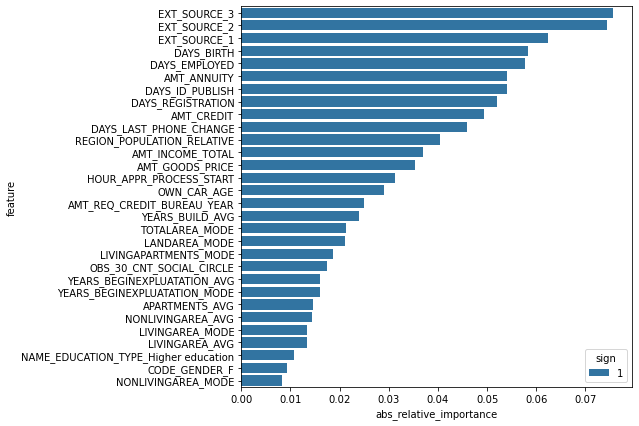

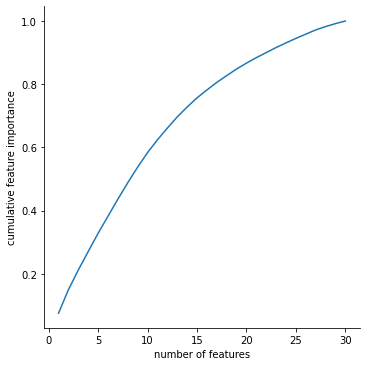

In [124]:
selected_features = features[pipeline_lgb_red.named_steps['feature_selection'].get_support()]
A = features_importance_rdf(pipeline_lgb_red.named_steps['estimator'],selected_features,plot=True,n_features_cum=30)

In [150]:
scores[['f1_valid','f1_test']].sort_values(by='f1_test',ascending=False)

,f1_valid,f1_test
lgb_red_busi,0.283219,0.265965
lgb_red,0.280891,0.265639
lgb,0.286486,0.265187
lr_red,0.251286,0.249654
lr,0.253691,0.248996
lr_red_busi,0.252074,0.248505
sgd,0.192715,0.191240
sgd_red_busi,0.185902,0.175197
sgd_red,0.178392,0.171137
tree,0.199210,0.149072


### Removing colinearity (not used in presentation)

In [208]:
X_train_under_col=X_train_under.drop(columns=couples['feature_1'])
X_test_col=X_test.drop(columns=couples['feature_1'])
features_col=features.drop(couples['feature_1'])

In [249]:
scores = scores.append(compute_score(pipeline_tree_red,
                                    X_train_under_col,
                                    y_train_under,
                                    X_test_col,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='tree_red_col'))

scores = scores.append(compute_score(pipeline_tree,
                                    X_train_under_col,
                                    y_train_under,
                                    X_test_col,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='tree_col'))

In [250]:
scores = scores.append(compute_score(pipeline_lda_red,
                                    X_train_under_col,
                                    y_train_under,
                                    X_test_col,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='lda_red_col'))

scores = scores.append(compute_score(pipeline_lda,
                                    X_train_under_col,
                                    y_train_under,
                                    X_test_col,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='lda_col'))

In [251]:
scores = scores.append(compute_score(pipeline_lr_red,
                                    X_train_under_col,
                                    y_train_under,
                                    X_test_col,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='lr_red_col'))

scores = scores.append(compute_score(pipeline_lr,
                                    X_train_under_col,
                                    y_train_under,
                                    X_test_col,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='lr_col'))

In [252]:
scores = scores.append(compute_score(pipeline_rdf_red,
                                    X_train_under_col,
                                    y_train_under,
                                    X_test_col,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='rdf_red_col'))

scores = scores.append(compute_score(pipeline_rdf,
                                    X_train_under_col,
                                    y_train_under,
                                    X_test_col,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='rdf_col'))

In [253]:
scores = scores.append(compute_score(pipeline_sgd_red,
                                    X_train_under_col,
                                    y_train_under,
                                    X_test_col,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='sgd_red_col'))

scores = scores.append(compute_score(pipeline_sgd,
                                    X_train_under_col,
                                    y_train_under,
                                    X_test_col,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='sgd_col'))

In [254]:
scores = scores.append(compute_score(pipeline_lgb_red,
                                   X_train_under_col,
                                    y_train_under,
                                    X_test_col,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='lgb_red_col'))

scores = scores.append(compute_score(pipeline_lgb,
                                    X_train_under_col,
                                    y_train_under,
                                    X_test_col,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='lgb_col'))

In [255]:
scores.sort_values(by='f1_test',ascending=False)

,roc_auc_train,f1_train,roc_auc_test,f1_test
lgb_col,0.716545,0.256738,0.703163,0.253562
lgb_red,0.716906,0.257832,0.698250,0.251263
lgb,0.721033,0.260042,0.703182,0.250638
lr_red_col,0.714482,0.248522,0.726332,0.249779
lgb_red_col,0.715494,0.254326,0.697304,0.249715
lr,0.710416,0.248315,0.720972,0.249256
lr_col,0.709534,0.248059,0.720713,0.246341
lr_red,0.715210,0.249042,0.719045,0.241086
sgd,0.616232,0.187884,0.603552,0.195494
sgd_col,0.629022,0.194534,0.607583,0.193242


# Feature Engineering

## Synthetic features using PCA (not used in presentation)

In [ ]:
pca = PCA(n_components=2)
pca.fit(X_train_std)
pca.explained_variance_ratio_

In [ ]:
PC1 = pd.DataFrame(pca.components_[0],columns=['coef'])
PC1['feature'] = features
PC2 = pd.DataFrame(pca.components_[1],columns=['coef'])
PC2['feature'] = features

In [ ]:
PC1 = PC1.sort_values(by='coef',ascending=False)
PC2 = PC2.sort_values(by='coef',ascending=False)

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(data=PC1.head(30),x ='coef',y='feature')

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(data=PC2.head(30),x ='coef',y='feature')

In [ ]:
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [ ]:
X_train_pca = np.hstack((X_train_std,X_train_pca))
X_test_pca = np.hstack((X_test_std,X_test_pca))

In [ ]:
features_pca = features.append(pd.Index(['PC1','PC2']))

In [ ]:
X_train_pca.shape

In [ ]:
lg = LogisticRegression(C=0.001,class_weight='balanced')
lg.fit(X_train_pca,y_train)

In [ ]:
A =features_importance_lg(lg,features_pca,n_features=40,plot = True)

In [ ]:
rdf.fit(X_train_pca,y_train)

In [ ]:
A = features_importance_rdf(rdf,features_pca,n_features=40,plot = True)

## Business Features

### Creating the features

In [136]:
def create_features(df):
        data = df.copy()
        data.loc[:,'ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
        data.loc[:,'CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
        data.loc[:,'DAYS_EMPLOYED_DAYS_BIRTH_RATIO'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
        data.loc[:,'TOTAL_CREDIT_LENGTH_MONTH'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
        return data

In [137]:
features_busi= create_features(app_kaggle).columns

In [6]:
def create_pipeline_red_busi(estimator,label,best_nb_feat):
    '''create and returns a pipeline with business features creation and feature selection'''
    pipeline = Pipeline([('feature_eng', FunctionTransformer(func=create_features)),
                         ('imp', SimpleImputer(strategy='median')),
                         ('scaler' , StandardScaler()),
                         ('feature_selection', SelectFromModel(estimator,max_features=best_nb_feat[label])),
                         ('estimator' , estimator)])     
    return pipeline

### Logistic Regression

In [139]:
pipeline_lr_red_busi = create_pipeline_red_busi(LogisticRegression(C = 0.01, max_iter = 1000, class_weight = 'balanced'),
                                                label='lr',
                                                best_nb_feat = best_nb_feat)

scores = scores.append(compute_score(pipeline_lr_red_busi,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='lr_red_busi'))



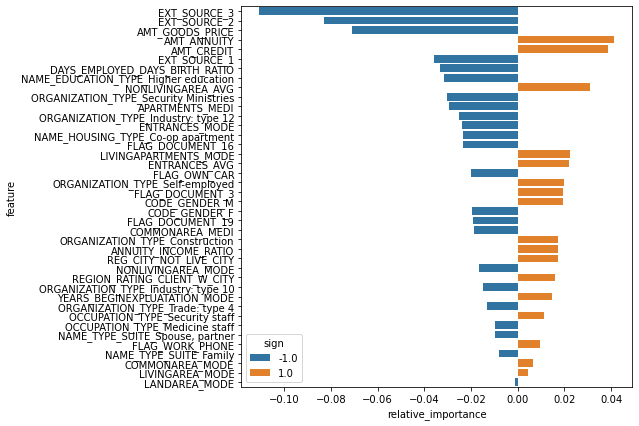

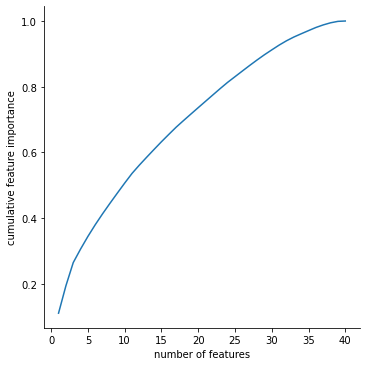

In [140]:
selected_features = features_busi[pipeline_lr_red_busi.named_steps['feature_selection'].get_support()]
A = features_importance_lg(pipeline_lr_red_busi.named_steps['estimator'],selected_features,plot=True,n_features_cum=40)

### Random Forest

In [141]:
pipeline_rdf_red_busi = create_pipeline_red_busi(RandomForestClassifier(n_estimators= 100, class_weight="balanced",criterion='gini'),
                                                 label='rdf',
                                                 best_nb_feat = best_nb_feat)

scores = scores.append(compute_score(pipeline_rdf_red_busi,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='rdf_red_busi'))



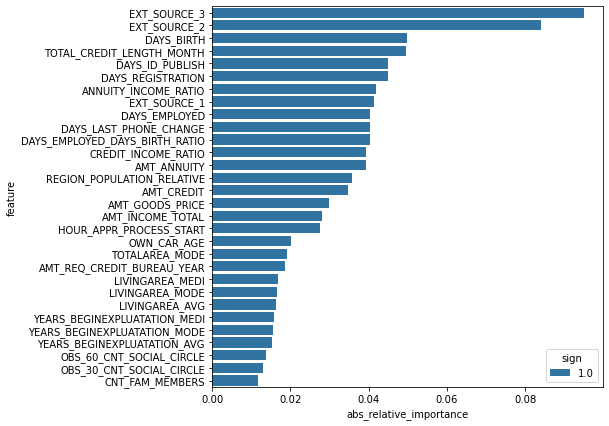

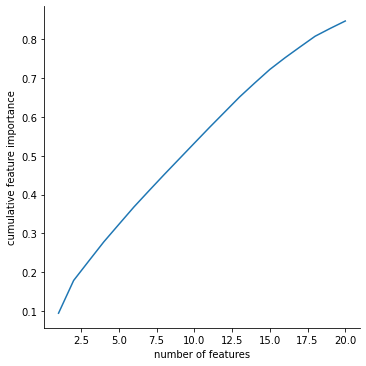

In [142]:
selected_features = features_busi[pipeline_rdf_red_busi.named_steps['feature_selection'].get_support()]
A = features_importance_rdf(pipeline_rdf_red_busi.named_steps['estimator'],selected_features,plot=True,n_features_cum=20)

### SGD 

In [143]:
pipeline_sgd_red_busi = create_pipeline_red_busi(SGDClassifier(class_weight='balanced',loss='modified_huber'),
                                                 label='sgd',
                                                 best_nb_feat = best_nb_feat)

scores = scores.append(compute_score(pipeline_sgd_red_busi,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='sgd_red_busi'))



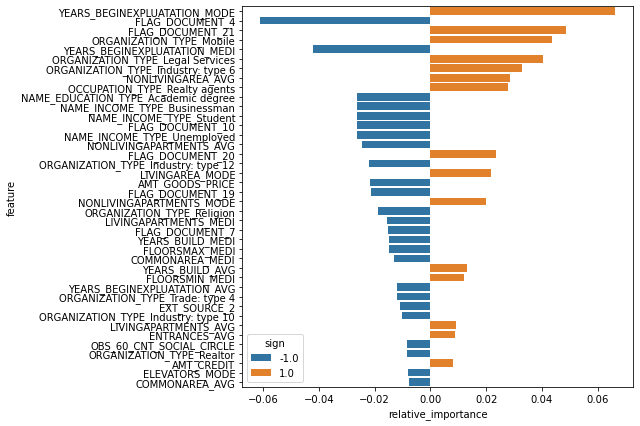

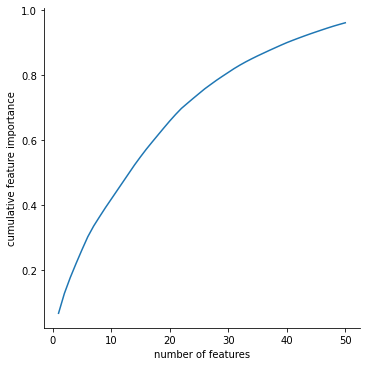

In [144]:
selected_features = features_busi[pipeline_sgd_red_busi.named_steps['feature_selection'].get_support()]
A = features_importance_lg(pipeline_sgd_red_busi.named_steps['estimator'],selected_features,plot=True,n_features_cum=50)

### LGB

In [145]:
pipeline_lgb_red_busi = create_pipeline_red_busi(LGBMClassifier(class_weight='balanced'),
                                                 label='lgb',
                                                 best_nb_feat = best_nb_feat)

scores = scores.append(compute_score(pipeline_lgb_red_busi,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='lgb_red_busi'))



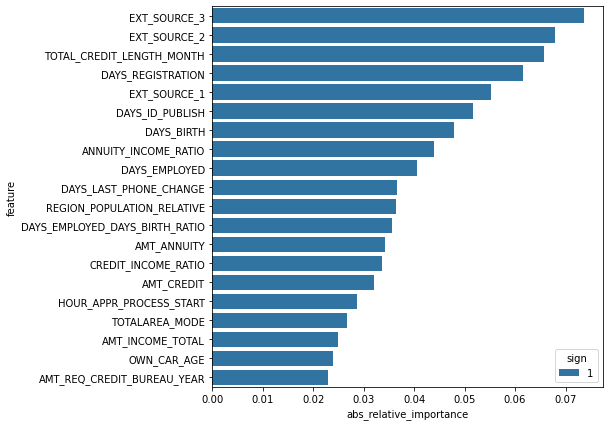

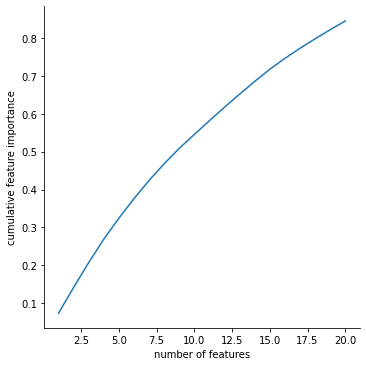

In [146]:
selected_features = features_busi[pipeline_lgb_red_busi.named_steps['feature_selection'].get_support()]
A = features_importance_rdf(pipeline_lgb_red_busi.named_steps['estimator'],selected_features,plot=True,n_features_cum=20,n_features_plot=20)

In [147]:
scores = scores.append(compute_score(dummy_cls,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=5,random_state=1),
                                    label ='dummy'))

In [151]:
scores[['f1_valid','f1_test']].sort_values(by='f1_test',ascending=False)

,f1_valid,f1_test
lgb_red_busi,0.283219,0.265965
lgb_red,0.280891,0.265639
lgb,0.286486,0.265187
lr_red,0.251286,0.249654
lr,0.253691,0.248996
lr_red_busi,0.252074,0.248505
sgd,0.192715,0.191240
sgd_red_busi,0.185902,0.175197
sgd_red,0.178392,0.171137
tree,0.199210,0.149072


### Kaggle submission

In [350]:
pipeline_lgb_red.fit(X,y)

Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=LGBMClassifier(class_weight='balanced'),
                                 max_features=30)),
                ('estimator', LGBMClassifier(class_weight='balanced'))])

In [351]:
kaggle_submit(pipeline_lgb_red,app_kaggle,'lgb_red.csv')

In [352]:
pipeline_lgb_red_busi.fit(X,y)

Pipeline(steps=[('feature_eng',
                 FunctionTransformer(func=<function create_features at 0x0000022E2AFE0430>)),
                ('imp', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=LGBMClassifier(class_weight='balanced'),
                                 max_features=30)),
                ('estimator', LGBMClassifier(class_weight='balanced'))])

In [354]:
kaggle_submit(pipeline_lgb_red_busi,app_kaggle,'lgb_red_busi.csv')

# Tuning the selected model

## Hyperparameter tuning

In [7]:
def show_performance(CV):
    '''Shows the results of a Cross Validation'''
    print(f'best parameter : {CV.best_params_}')
    print("Cross validation results :")
    for mean, std, params in zip(
        CV.cv_results_['mean_test_score'], # score moyen
        CV.cv_results_['std_test_score'],  # écart-type du score
        CV.cv_results_['params']           # valeur de l'hyperparamètre
                                ):

             print("{} = {:.3f} (+/-{:.03f}) for {}".format(
                                                            CV.get_params()['scoring'],
                                                             mean,
                                                             std*2,
                                                             params
                                                            ))

### Using GridSearch (iteratively to reduce computation time)

#### iteration 1

In [170]:
pipeline_lgb_tuning = Pipeline([('feature_eng', FunctionTransformer(func=create_features)),
                               ('imp', SimpleImputer()),
                               ('scaler' , StandardScaler()),
                               ('feature_selection', SelectFromModel(LGBMClassifier(class_weight='balanced'),max_features = best_nb_feat['lgb'])),
                               ('lgb', LGBMClassifier(class_weight='balanced'))])     

In [153]:
CV_lgb = GridSearchCV(pipeline_lgb_tuning,
                  param_grid = {'imp__strategy': ['median','mean','most_frequent'],
                                'lgb__num_leaves':[50,200,500],
                                'lgb__learning_rate':[0.001,0.01,1],
                                'lgb__n_estimators':[10,100,300],                                
                                },
                  scoring = 'f1',
                  verbose=True,
                  cv=3)

In [ ]:
CV_lgb.fit(X_train_under, y_train_under) 

In [ ]:
CV_lgb.best_params_

#### iteration 2

In [136]:
CV_lgb = GridSearchCV(pipeline_lgb_tuning,
                  param_grid = {'imp__strategy': ['most_frequent'],
                                'lgb__num_leaves':[25,50,75],
                                'lgb__learning_rate':[0.009,0.01,0.011],
                                'lgb__n_estimators':[200,300,400]},
                  scoring = 'f1',
                  verbose=True,
                  cv=3)

In [137]:
CV_lgb.fit(X_train_under, y_train_under) 

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  7.8min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feature_eng',
                                        FunctionTransformer(func=<function create_features at 0x000001163B726CA0>)),
                                       ('imp', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(class_weight='balanced'),
                                                        max_features=50)),
                                       ('lgb',
                                        LGBMClassifier(class_weight='balanced'))]),
             param_grid={'imp__strategy': ['most_frequent'],
                         'lgb__learning_rate': [0.009, 0.01, 0.011],
                         'lgb__n_estimators': [200, 300, 400],
                         'lgb__num_leaves': [25, 50, 75]},
             scoring='f1', verbose=True)

In [138]:
CV_lgb.best_params_

{'imp__strategy': 'most_frequent',
 'lgb__learning_rate': 0.011,
 'lgb__n_estimators': 400,
 'lgb__num_leaves': 75}

#### iteration 3

In [139]:
CV_lgb = GridSearchCV(pipeline_lgb_tuning,
                  param_grid = {'imp__strategy': ['most_frequent'],
                                'lgb__num_leaves':[70,80,90],
                                'lgb__learning_rate':[0.15,0.2],
                                'lgb__n_estimators':[350,450,550]},
                  scoring = 'f1',
                  verbose=True,
                  cv=3)

In [141]:
CV_lgb.fit(X_train_under, y_train_under)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  7.1min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feature_eng',
                                        FunctionTransformer(func=<function create_features at 0x000001163B726CA0>)),
                                       ('imp', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(class_weight='balanced'),
                                                        max_features=50)),
                                       ('lgb',
                                        LGBMClassifier(class_weight='balanced'))]),
             param_grid={'imp__strategy': ['most_frequent'],
                         'lgb__learning_rate': [0.15, 0.2],
                         'lgb__n_estimators': [350, 450, 550],
                         'lgb__num_leaves': [70, 80, 90]},
             scoring='f1', verbose=True)

In [142]:
CV_lgb.best_params_

{'imp__strategy': 'most_frequent',
 'lgb__learning_rate': 0.15,
 'lgb__n_estimators': 350,
 'lgb__num_leaves': 70}

#### iteration 4

In [143]:
CV_lgb = GridSearchCV(pipeline_lgb_tuning,
                  param_grid = {'imp__strategy': ['most_frequent'],
                                'lgb__num_leaves':[60,65,70],
                                'lgb__learning_rate':[0.012,0.015],
                                'lgb__n_estimators':[350,375,400]},
                  scoring = 'f1',
                  verbose=True,
                  cv=3)

In [144]:
CV_lgb.fit(X_train_under, y_train_under)  

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  6.0min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feature_eng',
                                        FunctionTransformer(func=<function create_features at 0x000001163B726CA0>)),
                                       ('imp', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(class_weight='balanced'),
                                                        max_features=50)),
                                       ('lgb',
                                        LGBMClassifier(class_weight='balanced'))]),
             param_grid={'imp__strategy': ['most_frequent'],
                         'lgb__learning_rate': [0.012, 0.015],
                         'lgb__n_estimators': [350, 375, 400],
                         'lgb__num_leaves': [60, 65, 70]},
             scoring='f1', verbose=True)

In [145]:
CV_lgb.best_params_

{'imp__strategy': 'most_frequent',
 'lgb__learning_rate': 0.015,
 'lgb__n_estimators': 375,
 'lgb__num_leaves': 70}

#### iteration 5

In [146]:
CV_lgb = GridSearchCV(pipeline_lgb_tuning,
                  param_grid = {'imp__strategy': ['most_frequent'],
                                'lgb__num_leaves':[68,70,72],
                                'lgb__learning_rate':[0.015,0.02],
                                'lgb__n_estimators':[350,375,400]},
                  scoring = 'f1',
                  verbose=True,
                  cv=3)

In [147]:
CV_lgb.fit(X_train_under, y_train_under)  

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  6.2min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feature_eng',
                                        FunctionTransformer(func=<function create_features at 0x000001163B726CA0>)),
                                       ('imp', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(class_weight='balanced'),
                                                        max_features=50)),
                                       ('lgb',
                                        LGBMClassifier(class_weight='balanced'))]),
             param_grid={'imp__strategy': ['most_frequent'],
                         'lgb__learning_rate': [0.015, 0.02],
                         'lgb__n_estimators': [350, 375, 400],
                         'lgb__num_leaves': [68, 70, 72]},
             scoring='f1', verbose=True)

In [148]:
CV_lgb.best_params_

{'imp__strategy': 'most_frequent',
 'lgb__learning_rate': 0.015,
 'lgb__n_estimators': 375,
 'lgb__num_leaves': 70}

#### iteration 6

In [157]:
CV_lgb = GridSearchCV(pipeline_lgb_tuning,
                  param_grid = {'imp__strategy': ['most_frequent'],
                                'lgb__num_leaves':[69,70,71],
                                'lgb__learning_rate':[0.015],
                                'lgb__n_estimators':[362,375,387]},
                  scoring = 'f1',
                  verbose=True,
                  cv=3)

In [158]:
CV_lgb.fit(X_train_under, y_train_under)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  3.5min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feature_eng',
                                        FunctionTransformer(func=<function create_features at 0x0000016EB3E26F70>)),
                                       ('imp', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(class_weight='balanced'),
                                                        max_features=50)),
                                       ('lgb',
                                        LGBMClassifier(class_weight='balanced'))]),
             param_grid={'imp__strategy': ['most_frequent'],
                         'lgb__learning_rate': [0.015],
                         'lgb__n_estimators': [362, 375, 387],
                         'lgb__num_leaves': [69, 70, 71]},
             scoring='f1', verbose=True)

In [159]:
CV_lgb.best_params_

{'imp__strategy': 'most_frequent',
 'lgb__learning_rate': 0.015,
 'lgb__n_estimators': 375,
 'lgb__num_leaves': 71}

In [155]:
kaggle_submit(CV_lgb.best_estimator_,app_kaggle,'lgb2.csv')

In [161]:
scores = scores.append(compute_score(CV_lgb.best_estimator_,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=2,random_state=1),
                                    label ='lgb_red_busi_opt_grid'))

In [168]:
scores[['f1_valid','f1_test']].sort_values(by='f1_test',ascending=False)

,f1_valid,f1_test
lgb_red_busi_opt_grid,0.300125,0.276366
lgb_red_busi_opt_rdm,0.300569,0.273606
lgb_red_busi,0.283219,0.265965
lgb_red,0.280891,0.265639
lgb,0.286486,0.265187
lr_red,0.251286,0.249654
lr,0.253691,0.248996
lr_red_busi,0.252074,0.248505
sgd,0.192715,0.191240
sgd_red_busi,0.185902,0.175197


### using random search

In [163]:
rdmCV_lgb = RandomizedSearchCV(pipeline_lgb_tuning,
                              param_distributions = {'imp__strategy': ['median','mean','most_frequent'],
                                                     'lgb__num_leaves':[70,80,90,100,110,120,130],
                                                     'lgb__learning_rate':[0.01],
                                                     'lgb__n_estimators':[300,330,360,390,420,450,480]
                                                    },
                              scoring = 'f1',
                              cv=3,
                              n_iter=40
                              )

In [164]:
rdmCV_lgb.fit(X_train_under, y_train_under)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('feature_eng',
                                              FunctionTransformer(func=<function create_features at 0x0000016EB3E26F70>)),
                                             ('imp', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('feature_selection',
                                              SelectFromModel(estimator=LGBMClassifier(class_weight='balanced'),
                                                              max_features=50)),
                                             ('lgb',
                                              LGBMClassifier(class_weight='balanced'))]),
                   n_iter=40,
                   param_distributions={'imp__strategy': ['median', 'mean',
                                                          'most_frequent'],
                                        'lgb__learning_rate

In [165]:
rdmCV_lgb.best_params_

{'lgb__num_leaves': 70,
 'lgb__n_estimators': 420,
 'lgb__learning_rate': 0.01,
 'imp__strategy': 'most_frequent'}

In [166]:
scores = scores.append(compute_score(rdmCV_lgb.best_estimator_,
                                    X_train_under,
                                    y_train_under,
                                    X_test,
                                    y_test,
                                    cv = RepeatedStratifiedKFold(n_splits=4,n_repeats=2,random_state=1),
                                    label ='lgb_red_busi_opt_rdm'))

## Comparing performances and selecting best model

In [169]:
scores[['f1_valid','f1_test']].sort_values(by='f1_test',ascending=False)

,f1_valid,f1_test
lgb_red_busi_opt_grid,0.300125,0.276366
lgb_red_busi_opt_rdm,0.300569,0.273606
lgb_red_busi,0.283219,0.265965
lgb_red,0.280891,0.265639
lgb,0.286486,0.265187
lr_red,0.251286,0.249654
lr,0.253691,0.248996
lr_red_busi,0.252074,0.248505
sgd,0.192715,0.191240
sgd_red_busi,0.185902,0.175197


### Selecting the best model

In [171]:
my_model = Pipeline([('feature_eng', FunctionTransformer(func=create_features)),
                               ('imp', SimpleImputer(strategy='most_frequent')),
                               ('scaler' , StandardScaler()),
                               ('feature_selection', SelectFromModel(LGBMClassifier(class_weight='balanced'),max_features = best_nb_feat['lgb'])),
                               ('lgb', LGBMClassifier(class_weight='balanced',learning_rate=0.015,n_estimators=375,num_leaves=71))])     

In [172]:
my_model.fit(X_train,y_train)

Pipeline(steps=[('feature_eng',
                 FunctionTransformer(func=<function create_features at 0x0000016EB3E26F70>)),
                ('imp', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=LGBMClassifier(class_weight='balanced'),
                                 max_features=30)),
                ('lgb',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.015,
                                n_estimators=375, num_leaves=71))])

### Confusion matrix

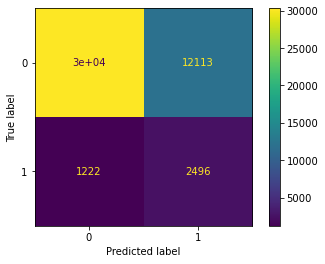

In [173]:
plot_confusion_matrix(my_model,X_test,y_test)

In [86]:
kaggle_submit(my_model,app_kaggle.drop(columns='DAYS_EMPLOYED_ANOM'),output_name='my_model.csv')

# Interpretation

## Undersampling Test data

In [206]:
X_test_under, y_test_under = resample(X_test,y_test,n_samples = 2000, stratify = y_test,random_state=4)

## Feature importance

In [207]:
my_model = Pipeline([('feature_eng', FunctionTransformer(func=create_features)),
                               ('imp', SimpleImputer(strategy='most_frequent')),
                               ('scaler' , StandardScaler()),
                               ('feature_selection', SelectFromModel(LGBMClassifier(class_weight='balanced'),max_features = best_nb_feat['lgb'])),
                               ('lgb', LGBMClassifier(class_weight='balanced',learning_rate=0.015,n_estimators=375,num_leaves=71))])     

In [208]:
my_model.fit(X_train_under,y_train_under)

Pipeline(steps=[('feature_eng',
                 FunctionTransformer(func=<function create_features at 0x0000016EB3E26F70>)),
                ('imp', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=LGBMClassifier(class_weight='balanced'),
                                 max_features=30)),
                ('lgb',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.015,
                                n_estimators=375, num_leaves=71))])

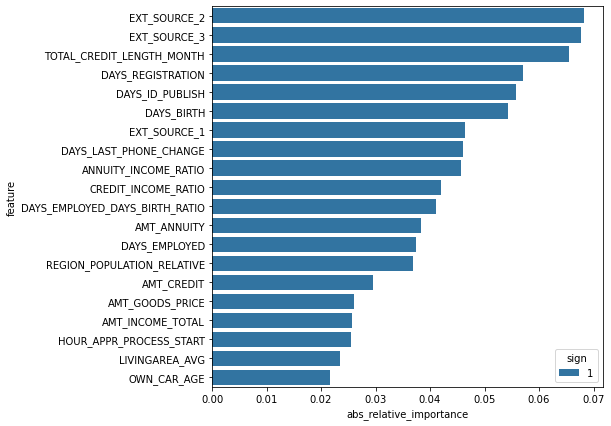

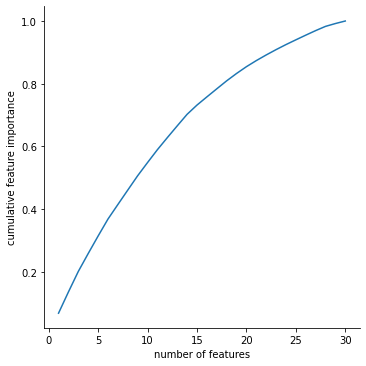

In [209]:
selected_features = features_busi[my_model.named_steps['feature_selection'].get_support()]
A = features_importance_rdf(my_model.named_steps['lgb'],selected_features,plot=True,n_features_cum=30,n_features_plot=20)

In [58]:
kaggle_submit(my_model,app_kaggle,'lgb_opt.csv')

## Permutation importance

## On feature after preprocessing

Creating preprocessing pipeline

In [210]:
data_pipeline = Pipeline([('feature_eng', FunctionTransformer(func=create_features)),
                          ('imp', SimpleImputer(strategy='most_frequent')),
                          ('scaler' , StandardScaler()),
                          ('feature_selection', SelectFromModel(LGBMClassifier(class_weight='balanced'),max_features=best_nb_feat['lgb']))]
                          )   

extracting the model

In [211]:
my_lgb = my_model.named_steps['lgb']

Calculating the preprocessed data

In [212]:
X_train_interp = data_pipeline.fit_transform(X_train_under,y_train_under)
X_test_interp = data_pipeline.transform(X_test_under)

In [213]:
X_train_interp = pd.DataFrame(X_train_interp,
                              columns = features_busi[data_pipeline.named_steps['feature_selection'].get_support()],
                              index=X_train_under.index)

In [214]:
X_test_interp = pd.DataFrame(X_test_interp,
                              columns = features_busi[data_pipeline.named_steps['feature_selection'].get_support()],
                              index=X_test_under.index)

Calculating permutation

In [215]:


perm = PermutationImportance(my_lgb, random_state=4, scoring='f1').fit(X_test_interp, y_test_under)


In [216]:
eli5.show_weights(perm, feature_names = X_test_interp.columns.to_list(),top=None)

Weight,Feature
0.0288 ± 0.0213,EXT_SOURCE_3
0.0201 ± 0.0447,EXT_SOURCE_2
0.0134 ± 0.0145,AMT_GOODS_PRICE
0.0103 ± 0.0101,OWN_CAR_AGE
0.0080 ± 0.0112,DAYS_LAST_PHONE_CHANGE
0.0074 ± 0.0099,DAYS_EMPLOYED_DAYS_BIRTH_RATIO
0.0072 ± 0.0045,REGION_POPULATION_RELATIVE
0.0065 ± 0.0097,AMT_INCOME_TOTAL
0.0063 ± 0.0254,TOTAL_CREDIT_LENGTH_MONTH
0.0062 ± 0.0140,CODE_GENDER_F


## On features before scaling

In [217]:
X_test = X_test.drop(columns=['DAYS_EMPLOYED_ANOM'])
X_train = X_train.drop(columns=['DAYS_EMPLOYED_ANOM'])
X_test_under = X_test_under.drop(columns=['DAYS_EMPLOYED_ANOM'])
X_train_under = X_train_under.drop(columns=['DAYS_EMPLOYED_ANOM'])

In [218]:
data_pipeline_split1 = Pipeline([('feature_eng', FunctionTransformer(func=create_features)),
                          ('imp', SimpleImputer(strategy='most_frequent'))])
                         

In [219]:
my_split = Pipeline([('scaler' , StandardScaler()),
                     ('feature_selection', SelectFromModel(LGBMClassifier(class_weight='balanced'),max_features = 50)),
                     ('lgb', LGBMClassifier(class_weight='balanced',learning_rate=0.01,n_estimators=390,num_leaves=110))])     

In [220]:
X_train_interp_s = data_pipeline_split1.fit_transform(X_train_under,y_train_under)
X_test_interp_s = data_pipeline_split1.transform(X_test_under)
features_interp_busi = create_features(X_train_under).columns

In [221]:
X_train_interp_s = pd.DataFrame(X_train_interp_s,
                              columns = features_interp_busi,
                              index=X_train_under.index)

In [222]:
X_test_interp_s = pd.DataFrame(X_test_interp_s,
                              columns = features_interp_busi,
                              index=X_test_under.index)

In [223]:
my_split.fit(X_train_interp_s,y_train_under)

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=LGBMClassifier(class_weight='balanced'),
                                 max_features=50)),
                ('lgb',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.01,
                                n_estimators=390, num_leaves=110))])

In [224]:
perm = PermutationImportance(my_split, random_state=1, scoring='f1').fit(X_test_interp_s, y_test_under)

In [225]:
eli5.show_weights(perm, feature_names = features_interp_busi.to_list(),top=20)

Weight,Feature
0.0267 ± 0.0502,EXT_SOURCE_3
0.0233 ± 0.0240,EXT_SOURCE_2
0.0170 ± 0.0156,EXT_SOURCE_1
0.0129 ± 0.0126,DAYS_REGISTRATION
0.0086 ± 0.0062,OWN_CAR_AGE
0.0078 ± 0.0205,DAYS_EMPLOYED_DAYS_BIRTH_RATIO
0.0076 ± 0.0084,AMT_CREDIT
0.0066 ± 0.0119,ANNUITY_INCOME_RATIO
0.0062 ± 0.0094,AMT_ANNUITY
0.0055 ± 0.0022,YEARS_BUILD_MODE


## Partial dependency

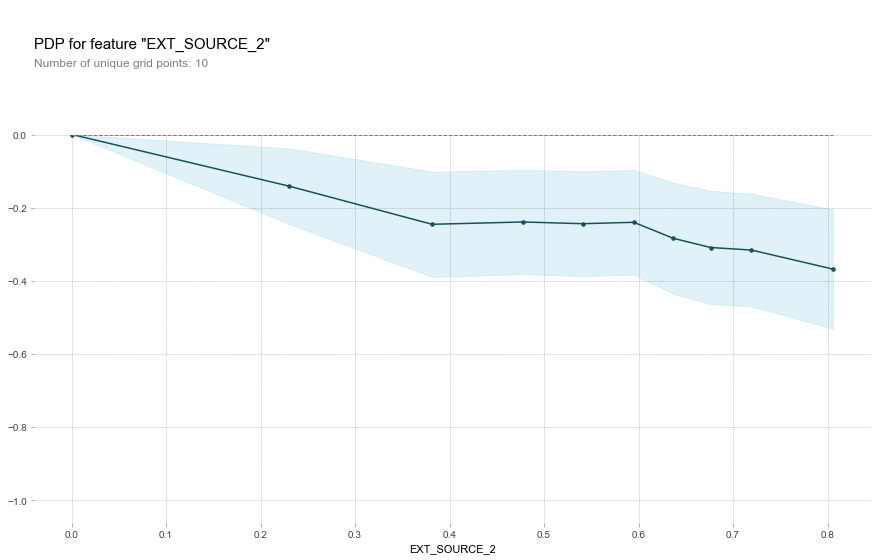

In [226]:
# Create the data that we will plot
pdp_ext_2 = pdp.pdp_isolate(model=my_split,
                            dataset=X_test_interp_s,
                            model_features = features_interp_busi.to_list(),
                            feature='EXT_SOURCE_2')

# plot it
pdp.pdp_plot(pdp_ext_2, 'EXT_SOURCE_2')
plt.show()

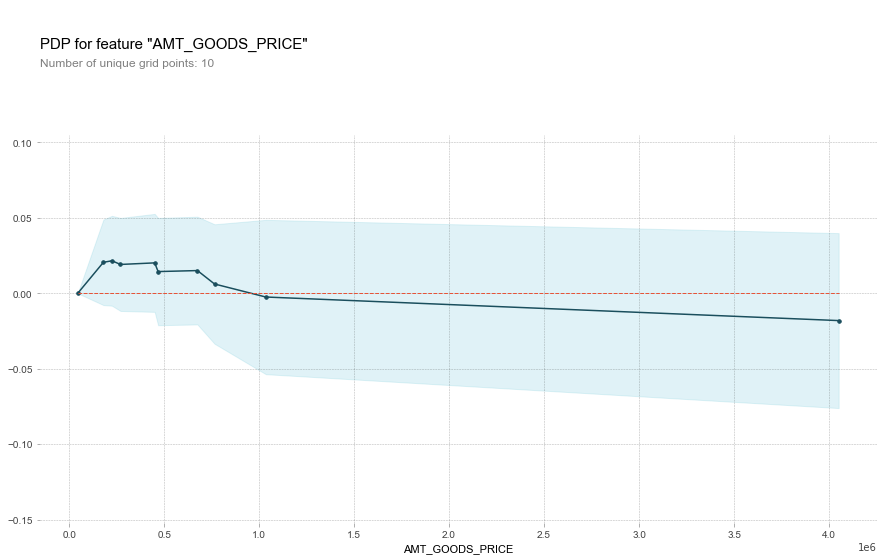

In [227]:
# Create the data that we will plot
pdp_price = pdp.pdp_isolate(model=my_split,
                            dataset=X_test_interp_s,
                            model_features = features_interp_busi.to_list(),
                            feature='AMT_GOODS_PRICE')

# plot it
pdp.pdp_plot(pdp_price, 'AMT_GOODS_PRICE')
plt.show()

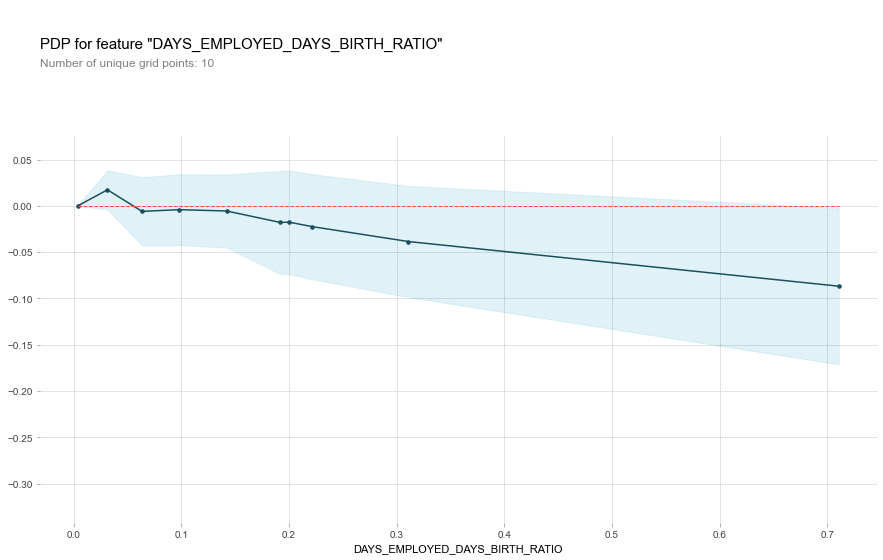

In [228]:
# Create the data that we will plot
pdp_birth_ratio = pdp.pdp_isolate(model=my_split,
                            dataset=X_test_interp_s,
                            model_features = features_interp_busi.to_list(),
                            feature='DAYS_EMPLOYED_DAYS_BIRTH_RATIO')

# plot it
pdp.pdp_plot(pdp_birth_ratio, 'DAYS_EMPLOYED_DAYS_BIRTH_RATIO')
plt.show()

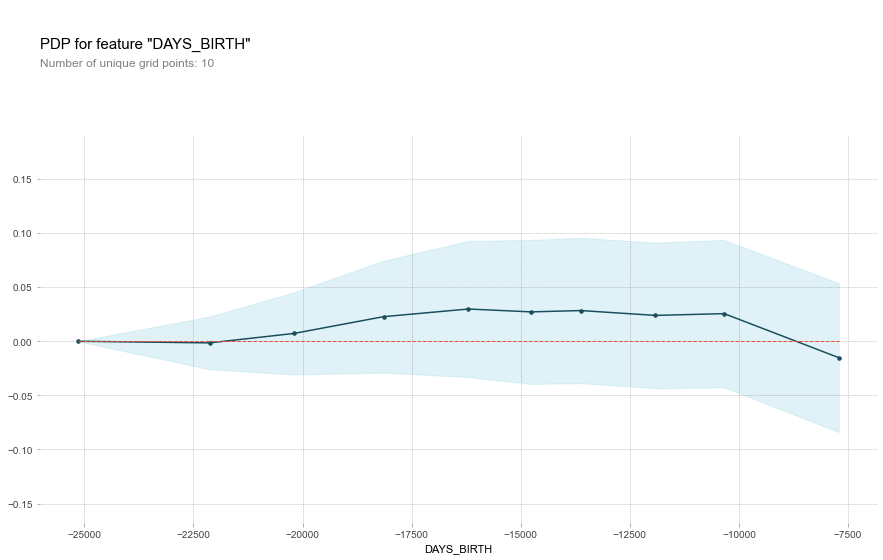

In [229]:
# Create the data that we will plot
pdp_birth = pdp.pdp_isolate(model=my_split,
                            dataset=X_test_interp_s,
                            model_features = features_interp_busi.to_list(),
                            feature='DAYS_BIRTH')

# plot it
pdp.pdp_plot(pdp_birth, 'DAYS_BIRTH')
plt.show()

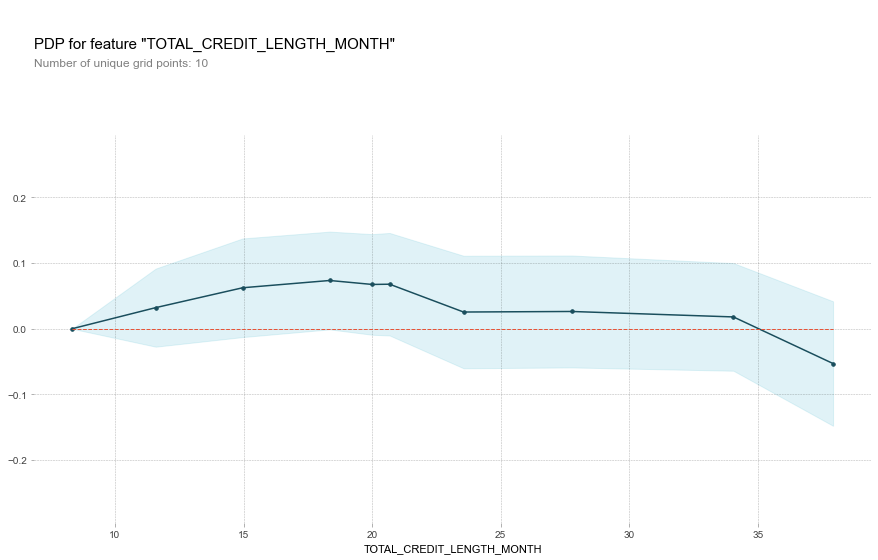

In [230]:
# Create the data that we will plot
pdp_length = pdp.pdp_isolate(model=my_split,
                            dataset=X_test_interp_s,
                            model_features = features_interp_busi.to_list(),
                            feature='TOTAL_CREDIT_LENGTH_MONTH')

# plot it
pdp.pdp_plot(pdp_length, 'TOTAL_CREDIT_LENGTH_MONTH')
plt.show()

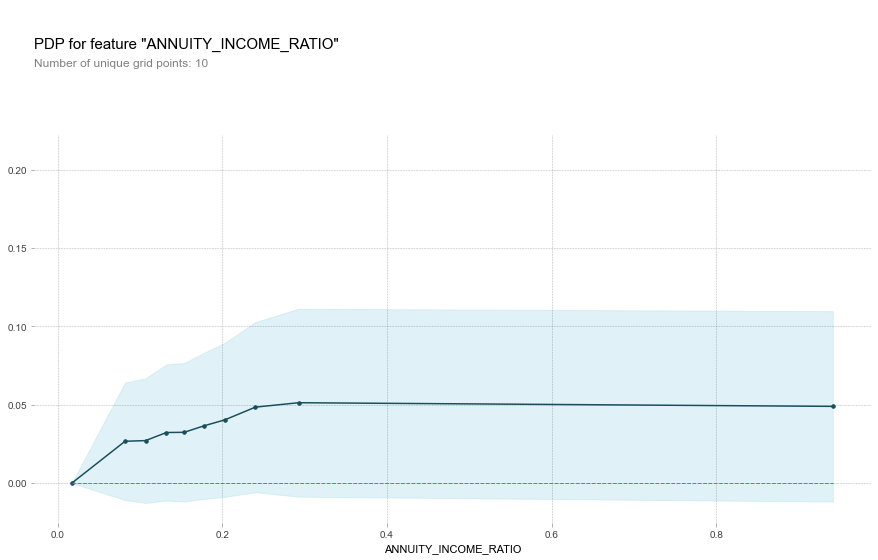

In [231]:
# Create the data that we will plot
pdp_annuity_ratio = pdp.pdp_isolate(model=my_split,
                            dataset=X_test_interp_s,
                            model_features = features_interp_busi.to_list(),
                            feature='ANNUITY_INCOME_RATIO')

# plot it
pdp.pdp_plot(pdp_annuity_ratio, 'ANNUITY_INCOME_RATIO')
plt.show()

## SHAP

### Local effects

In [232]:
y_pred = my_split.predict(X_test_interp_s)

In [233]:
ones=[]
i=0
for y in y_pred:
    
    if y == 1:
        ones.append(i)
    i+=1

In [234]:
sample = X_test_interp_s.iloc[ones[3],:].values.reshape(1,-1)

In [235]:
my_split.predict_proba(sample)

array([[0.43379185, 0.56620815]])

In [236]:
samples = X_test_interp_s.iloc[ones]

In [237]:
explainer = shap.KernelExplainer(my_split.predict_proba,shap.sample(X_train_interp_s,100))

In [244]:
shap_values = explainer.shap_values(samples.iloc[8])

In [245]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1],samples.iloc[8])

In [250]:
shap_values = explainer.shap_values(samples.iloc[14])

In [251]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1],samples.iloc[14])

### Global effects

In [252]:
X_shap, y_shap = resample(X_test_interp_s,y_test_under,n_samples = 50, stratify = y_test_under,random_state=2)

In [253]:
shap_values = explainer.shap_values(X_shap)

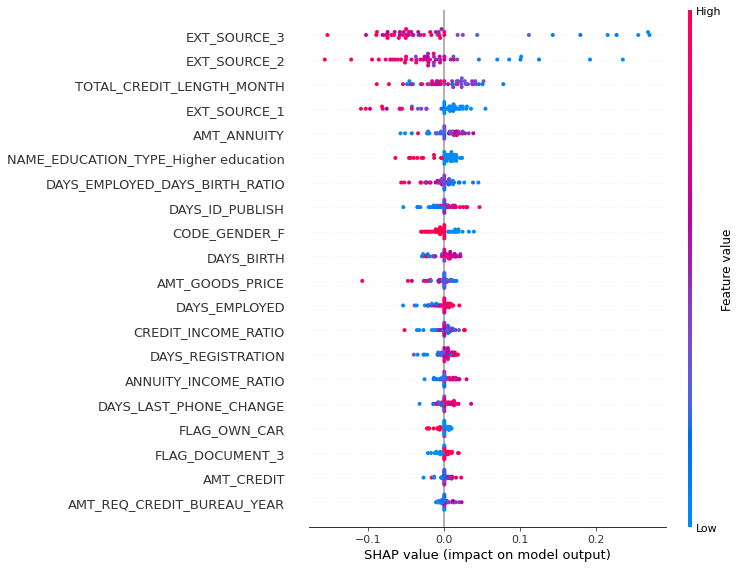

In [254]:
shap.summary_plot(shap_values[1], X_shap)